In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, Point
from tqdm import tqdm
from pathlib import Path

from s1_enumerator.stack import (collect_coverage_tiles, get_earliest_n_dates_per_path, get_s1_stack_by_dataframe)
from s1_enumerator import get_aoi_dataframe, enumerate_ifgs, distill_all_pairs

In [3]:
points = [Point(-163.26, 55.11),  # Aleutian 
          Point(-72.38,19.0),  # Haiti
          Point(35.26,38.76),  # Turkey
          Point(-120.0048,34.8923), # Los Padres
         ]

aoi_names = ['aleutian', 'haiti', 'turkey', 'los_padres_ca']

In [4]:
def get_aoi(point: Point) -> Polygon:
    return point.buffer(1)

In [5]:
aois = list(map(get_aoi, points))
aoi_dfs = list(map(get_aoi_dataframe, aois))

<AxesSubplot:>

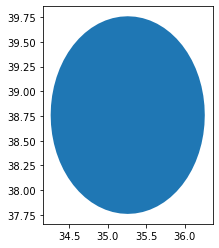

In [6]:
aoi_dfs[2].plot()

In [7]:
aoi_dir = Path('aoi')
aoi_dir.mkdir(exist_ok=True)

In [8]:
for df_aoi, name in zip(aoi_dfs, aoi_names):
    df_aoi.to_file(aoi_dir/f'{name}.geojson', driver='GeoJSON')

In [9]:
paths = sorted(list(aoi_dir.glob('*.geojson')))
paths

[PosixPath('aoi/aleutian.geojson'),
 PosixPath('aoi/haiti.geojson'),
 PosixPath('aoi/los_padres_ca.geojson'),
 PosixPath('aoi/turkey.geojson')]

# Coverage Test

In [10]:
out_dir = Path('coverage_data')
out_dir.mkdir(exist_ok=True)
COLS = ['sceneName','start_date_str', 'pathNumber', 'geometry']

for path in tqdm(paths):
    aoi = gpd.read_file(path).geometry.values[0]
    aoi_name = path.name.split('.')[0]    
    for n in [1, 2]:
        start_date = datetime.datetime(2021, 1, 1)
        n_dates_per_path= n 
        max_results = 1_000
        
        df_all = collect_coverage_tiles(aoi,
                                            start_date,
                                            min_dates_per_path=n_dates_per_path,
                                            max_results=max_results,
                                            path_number=None)
        df = get_earliest_n_dates_per_path(df_all, n_dates_per_path)
            
        
        df_all[COLS].to_file(out_dir / f'{aoi_name}_at_least_{n}.geojson', driver='GeoJSON')

        df[COLS].to_file(out_dir / f'{aoi_name}_exactly_{n}.geojson', driver='GeoJSON')

100%|███████████████████████████████████████████████████████| 4/4 [00:16<00:00,  4.14s/it]


# Tile Enumeration (Annual Pair)

In [10]:
out_dir = Path('enum_data')
out_dir.mkdir(exist_ok=True)

num_neighbors_ref = 3
num_neighbors_sec = 2

for enumeration_type in ['tile', 'path']:
    for path in tqdm(paths, desc=enumeration_type):
        aoi = gpd.read_file(path).geometry.values[0]
        aoi_name = path.name.split('.')[0]    

        ifg_pairs_tiles = enumerate_ifgs(aoi,
                                         min_reference_date=datetime.datetime(2021, 7, 9), 
                                         enumeration_type=enumeration_type,
                                         min_days_backward = 364, 
                                         num_neighbors_ref=num_neighbors_ref,
                                         num_neighbors_sec=num_neighbors_sec,
                                         temporal_window_days=60,
                                         min_ref_tile_overlap_perc=.1,
                                         min_tile_aoi_overlap_km2=1e3,
                                         minimum_path_intersection_km2=1e3,
                                         entire_s1_catalog=False
                                         )
        df_pairs = distill_all_pairs(ifg_pairs_tiles)
        df_test = df_pairs.sort_values(by=['path_number', 'reference_date']).reset_index(drop=True)
        file_name = f'{aoi_name}_annual_{enumeration_type}.geojson'
        df_test.drop(columns=['reference', 'secondary', 'hash_id']).to_file(out_dir/file_name)

path: 100%|█████████████████████████████████████████████████| 4/4 [01:17<00:00, 19.40s/it]


## Fixed Path Number

In [11]:
for enumeration_type in ['tile', 'path']:
    for path in tqdm(paths, desc=enumeration_type):
        aoi = gpd.read_file(path).geometry.values[0]
        aoi_name = path.name.split('.')[0]
        if 'padres' not in aoi_name:
            continue

        ifg_pairs_tiles = enumerate_ifgs(aoi,
                                         min_reference_date=datetime.datetime(2021, 7, 9), 
                                         enumeration_type=enumeration_type,
                                         min_days_backward = 364, 
                                         num_neighbors_ref=num_neighbors_ref,
                                         num_neighbors_sec=num_neighbors_sec,
                                         temporal_window_days=60,
                                         min_ref_tile_overlap_perc=.1,
                                         min_tile_aoi_overlap_km2=1e3,
                                         minimum_path_intersection_km2=1e3,
                                         path_numbers=[137],
                                         entire_s1_catalog=False
                                         )
        df_pairs = distill_all_pairs(ifg_pairs_tiles)
        df_test = df_pairs.sort_values(by=['path_number', 'reference_date']).reset_index(drop=True)
        file_name = f'{aoi_name}_annual_{enumeration_type}_137.geojson'
        df_test.drop(columns=['reference', 'secondary']).to_file(out_dir/file_name)

path: 100%|█████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.64s/it]


## Fixed Months

In [15]:
for enumeration_type in ['tile', 'path']:
    for path in tqdm(paths, desc=enumeration_type):
        aoi = gpd.read_file(path).geometry.values[0]
        aoi_name = path.name.split('.')[0]
        if 'padres' not in aoi_name:
            continue

        ifg_pairs_tiles = enumerate_ifgs(aoi,
                                         min_reference_date=datetime.datetime(2021, 7, 9), 
                                         enumeration_type=enumeration_type,
                                         min_days_backward = 364, 
                                         num_neighbors_ref=num_neighbors_ref,
                                         num_neighbors_sec=num_neighbors_sec,
                                         temporal_window_days=60,
                                         min_ref_tile_overlap_perc=.1,
                                         min_tile_aoi_overlap_km2=1e3,
                                         minimum_path_intersection_km2=1e3,
                                         path_numbers=[137],
                                         months=[7, 8],
                                         entire_s1_catalog=False
                                         )
        df_pairs = distill_all_pairs(ifg_pairs_tiles)
        df_test = df_pairs.sort_values(by=['path_number', 'reference_date']).reset_index(drop=True)
        file_name = f'{aoi_name}_annual_{enumeration_type}_fixed_months_137.geojson'
        df_test.drop(columns=['reference', 'secondary']).to_file(out_dir/file_name)

path: 100%|█████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.32s/it]
